# Beijing Air Quality Forecasting Starter Notebook

This notebook highlights the building of the model to forecast PM2.5 concentrations using historical air quality and weather data. Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) were the chosen to iterate with and try numerous ways to optimize them. This is due to their ability to capture temporal patterns in time-series data, enabling accurate predictions for proactive pollution control measures

This is imperativel because  although  air pollution can result form many things including gases,  PM2.5 (particulate matter ≤2.5µm), partciles are also a critical environmental concern in urban areas like Beijing. Exposure to high PM2.5 levels leads to respiratory diseases and premature deaths.


The strategies used until the best performing model and the decisions made will be explained as we move along

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import LeakyReLU

In [10]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Loading the data

The data used in this notebook provide readings of the PM2.5 particles in air in a period of three years from 2010 to 2013. It is what will be  used to train, test and even fine tune the lstm models in this notebook

In [11]:
# Load the datasets
df_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Data/air_quality_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Data/air_quality_test.csv')


# Exploring the data

In this section, the purpose was to explore your dataset with appropiate statistics and visualisations to understand it better.

In [12]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
df_train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [13]:
df_test.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096
1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096
2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096
3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096
4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096


In [14]:
df_train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [15]:
# checking for the data structure and null values
df_train.info()
df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


In [16]:
df_test.info()
df_test.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        13148 non-null  int64  
 1   DEWP      13148 non-null  float64
 2   TEMP      13148 non-null  float64
 3   PRES      13148 non-null  float64
 4   Iws       13148 non-null  float64
 5   Is        13148 non-null  float64
 6   Ir        13148 non-null  float64
 7   datetime  13148 non-null  object 
 8   cbwd_NW   13148 non-null  float64
 9   cbwd_SE   13148 non-null  float64
 10  cbwd_cv   13148 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.1+ MB


,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
datetime,0
cbwd_NW,0
cbwd_SE,0


## Insights from basic data exploration initiatives

- The training data is clean at some extent. This is beacsuse it has features names that are appropriate and would not cause naming issues.
- It also doesn't have alot of null values in all the columns except in the pm2.5 column. This implies that we have to handle those missing values.
-  Also, the data will need to be scaled, considering the readings and the features that we have in the dataset.

On the other hand, testing is clean with no null values and column naming issues as well.

# Data Pre-processing

After the basic insights from the above section, the next steps involves pre-processing the data for visualizations and also getting them ready to be fed to the model


In [17]:
# Ensuring 'datetime' column is in datetime format and setting it to be the index for our time series data
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

df_test['datetime'] = pd.to_datetime(df_test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
df_train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
df_test.set_index('datetime', inplace=True)


In [18]:
df_train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


In [19]:
df_test.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv
datetime,,,,,,,,,,
2013-07-02 04:00:00,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 05:00:00,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 06:00:00,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 07:00:00,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,1.448138,-0.732019,-0.522096
2013-07-02 08:00:00,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,1.448138,-0.732019,-0.522096


# Handle missing values

Upon examining the PM2.5 dataset, we identified the presence of missing values. While several methods exist to address missing data, such as forward fill, backward fill, and rolling averages, we opted for linear interpolation based on the specific characteristics of our dataset.

## Rationale for Choosing Linear Interpolation:

- Consecutive Missing Values: Our data exploration revealed numerous instances of consecutive missing entries, with some sequences extending up to 155 null values.

- Limitations of Forward and Backward Fill: Employing forward or backward fill in such scenarios would result in prolonged stretches of identical values, potentially distorting the natural variability and trends inherent in the data.

- Challenges with Rolling Averages: Rolling averages require a sufficient number of surrounding data points to compute meaningful values. In cases of extended missing sequences, this method becomes ineffective, as the necessary data context is absent.

- Doesn't require much computational power compared to other means like Seasonal Decomposition and others.

In [20]:
#  Exploring the null values distribution for choosing the right method

def count_consecutive_nas(series):
    na_groups = series.isna().astype(int).groupby(series.notna().astype(int).cumsum()).sum()
    return na_groups[na_groups > 0].value_counts().sort_index()

# Analyze each column with missing values
print("TRAIN DATA - Consecutive NA Counts:")
for col in df_train.columns:
    if df_train[col].isna().any():
        na_counts = count_consecutive_nas(df_train[col])
        print(f"\n* Column '{col}':")
        print(na_counts.to_string(header=False))

TRAIN DATA - Consecutive NA Counts:

* Column 'pm2.5':
1      84
2      18
3       2
4       3
5       3
6       3
7       6
8       3
9       3
10      3
12      1
14      2
16      2
17      1
19      2
20      1
22      2
23      1
24      3
29      2
37      1
40      1
42      1
44      1
48      1
52      1
54      1
63      1
67      1
68      1
72      1
74      2
76      1
91      1
99      1
127     1
155     1


In [21]:
#  Applying  linear interpolation for missing PM2.5 values
df_train['pm2.5'] = df_train['pm2.5'].interpolate(method='linear')

# Filling any remaining NaNs using forward fill, then backward fill
df_train['pm2.5'] = df_train['pm2.5'].fillna(method='ffill').fillna(method='bfill')

# Checking if there are any NaNs remain
print("Remaining missing values in PM2.5:", df_train['pm2.5'].isnull().sum())


Remaining missing values in PM2.5: 0


<ipython-input-21-0abead0de326>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['pm2.5'] = df_train['pm2.5'].fillna(method='ffill').fillna(method='bfill')


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       30676 non-null  int64  
 1   DEWP     30676 non-null  float64
 2   TEMP     30676 non-null  float64
 3   PRES     30676 non-null  float64
 4   Iws      30676 non-null  float64
 5   Is       30676 non-null  float64
 6   Ir       30676 non-null  float64
 7   cbwd_NW  30676 non-null  float64
 8   cbwd_SE  30676 non-null  float64
 9   cbwd_cv  30676 non-null  float64
 10  pm2.5    30676 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.8 MB


# Visualizing the data

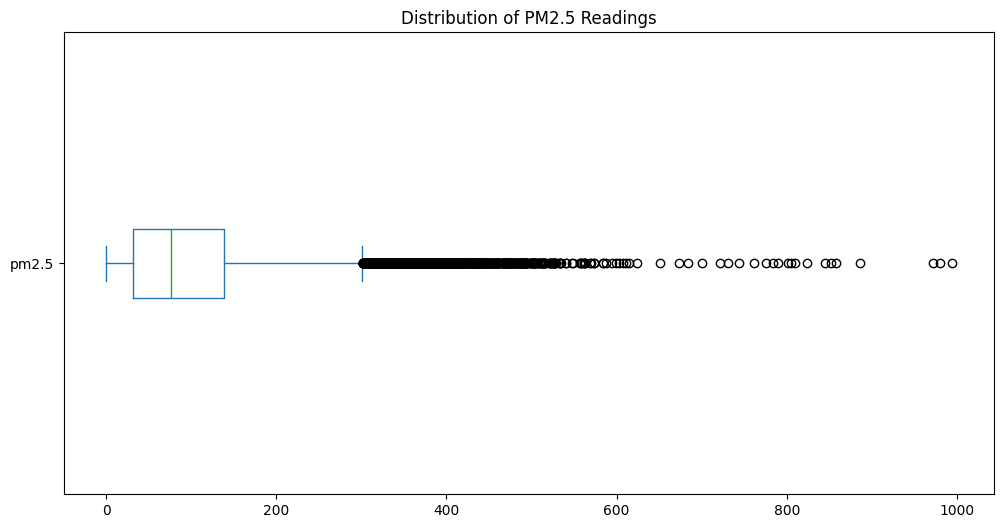

In [23]:
#Creating a  box plot to see the distribution of the pm2.5 readings
fig, ax = plt.subplots(figsize=(12, 6))
df_train["pm2.5"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings", ax=ax);


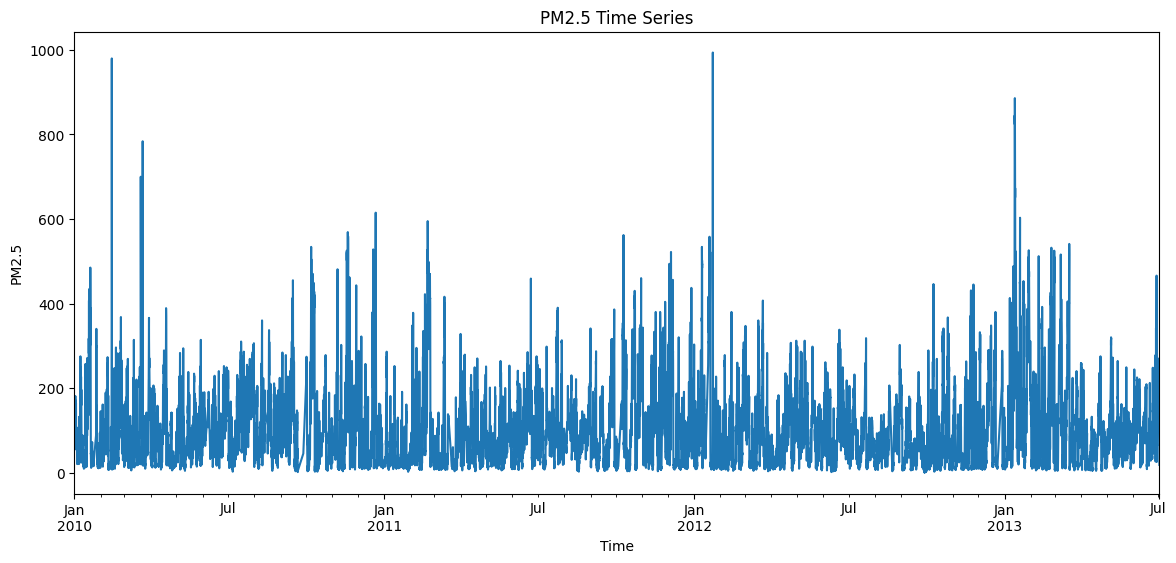

In [24]:
# Creating a timeseries plot to see trends in the data
fig, ax = plt.subplots(figsize=(14, 6))
df_train["pm2.5"].plot(xlabel="Time", ylabel="PM2.5", title="PM2.5 Time Series", ax=ax);


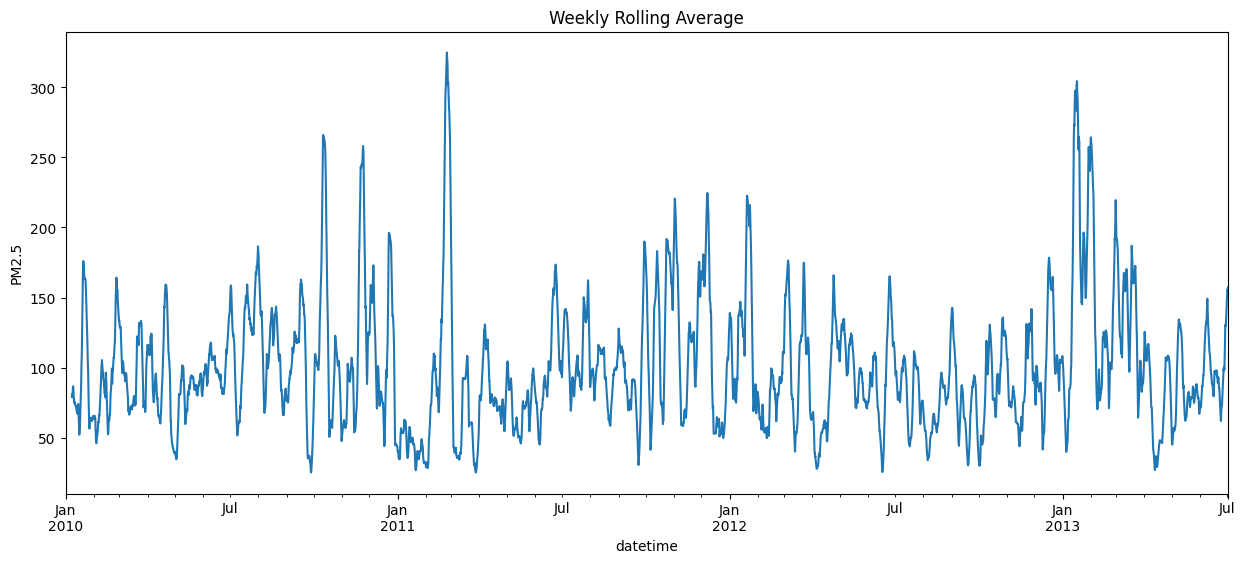

In [25]:
# Creating the weekly rolling average plot
fig, ax = plt.subplots(figsize=(15, 6))
df_train["pm2.5"].rolling(168).mean().plot(ax=ax, ylabel="PM2.5", title="Weekly Rolling Average");

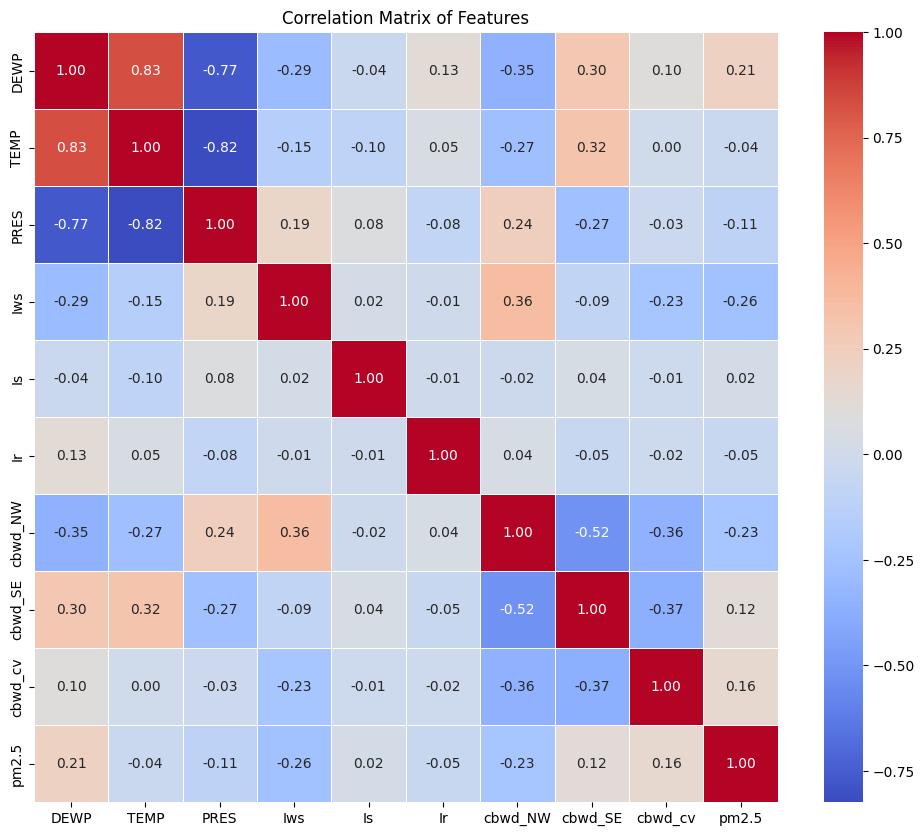

In [26]:
columns_for_correlation = df_train.drop(['No'], axis=1)

# Calculate the correlation matrix
correlation_matrix = columns_for_correlation.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.show()

# Observations from visualizations

- Skewed Distribution: Most PM2.5 readings are clustered at lower values (0–200 µg/m³), with a long tail extending to 800–1000 µg/m³.

- Outliers: Extreme values (>500 µg/m³) likely represent pollution events (eg., sandstorms, industrial accidents).

- Seasonality: Labels show January (winter) and July (summer). PM2.5 peaks in winter  and dips in summer.

# Separating features and target & Scaling

In [27]:
X_train = df_train.drop(['pm2.5', 'No'], axis=1)
y_train = df_train['pm2.5']

In [28]:
# Scaling the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.values)

In [29]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)

In [30]:
X_train_scaled.shape

(30676, 1, 9)

# Building The Models

For easy iterations and hyperparameter adjustments, the following functions were developed to ease reproducibility. Both basic lstms and bidirectional lstms were tried to see which one performs better

In [31]:
# Function to build LSTM models both basic and bidirectional

def build_lstm_model(
    input_shape,
    lstm_units=[32],
    activation='tanh',
    dropout_rate=0.2,
    optimizer='adam',
    learning_rate=None,
    use_bidirectional=False
):
    model = Sequential()

    for i, units in enumerate(lstm_units):
        return_sequences = i < len(lstm_units) - 1
        lstm_layer = LSTM(units, activation=activation, return_sequences=return_sequences)

        # Add either Bidirectional or standard LSTM
        if use_bidirectional:
            model.add(Bidirectional(lstm_layer, input_shape=input_shape if i == 0 else None))
        else:
            model.add(lstm_layer if i != 0 else LSTM(units, activation=activation, return_sequences=return_sequences, input_shape=input_shape))

        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    # Configure optimizer with custom learning rate
    if learning_rate:
        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer")
    else:
        opt = optimizer

    # Compile the model
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE
    )

    return model


In [32]:
# Defining a function that will evaluate the trained models

def evaluate_model_training(model, history, X_train, y_train, model_name="Model"):
    """
    Evaluate and visualize the training loss of a model.

    Parameters:
    - model: The trained Keras model.
    - history: The history object returned from model.fit().
    - X_train: Scaled training features.
    - y_train: Ground truth labels for training.
    - model_name: A custom name to display in the plots and outputs.

    Returns:
    - train_loss: The final MSE loss on the training data.
    """

    # Predict on training data
    train_predictions = model.predict(X_train)
    train_loss = np.mean((y_train - train_predictions.flatten()) ** 2)

    # Plot the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')
    plt.title(f'Loss on Training Data ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

    print(f"Final Training Loss ({model_name}): {train_loss:.4f}")
    return train_loss


In [33]:
# Refining the starter codes to create a function that will help to generate predictions for test data  using different models

def generate_submission(model, df_test, scaler, save_path, file_name="submission.csv"):
    """
    Generates a Kaggle-compatible submission file using the provided model and test data.

    Parameters:
    - model: Trained Keras model
    - df_test: DataFrame containing the test set (must include 'No' column)
    - scaler: Scaler object used to scale training data (e.g., MinMaxScaler or StandardScaler)
    - save_path: Path to directory where CSV will be saved
    - file_name: Name of the submission file (default: 'submission.csv')
    """
    # Step 1: Prepare test features
    X_test = df_test.drop(['No'], axis=1)

    # Step 2: Scale using the training scaler
    X_test_scaled = scaler.transform(X_test)

    # Step 3: Expand dimensions for LSTM input (samples, timesteps, features)
    X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

    # Step 4: Make predictions
    predictions = model.predict(X_test_scaled)

    # Step 5: Replace NaNs and convert to integers
    predictions = np.nan_to_num(predictions)
    predictions = np.round(predictions).astype(int)

    # Step 6: Create submission DataFrame
    submission = pd.DataFrame({
        'row ID': pd.to_datetime(df_test.index).strftime('%Y-%m-%d %-H:%M:%S'),
        'pm2.5': predictions.flatten()
    })

    # Step 7: Sort and save
    submission = submission.sort_values(by='row ID')
    submission_path = f"{save_path.rstrip('/')}/{file_name}"
    submission.to_csv(submission_path, index=False)

    print(f"Submission saved to: {submission_path}")


# Training And Evaluating Models & Making Predictions

In [34]:
#Re-defining the basic model initially provided using the helper function

model1 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[32],
    activation='relu',
    dropout_rate=0.0,
    optimizer='adam',
    use_bidirectional=False
)

# Display the model architecture
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Training the mode1
history1 = model1.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 122.0568 - loss: 15400.4209 - val_lambda: 87.8363 - val_loss: 13233.3027
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - lambda: 84.7424 - loss: 7587.9614 - val_lambda: 83.5764 - val_loss: 11293.3838
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 81.7836 - loss: 7058.7148 - val_lambda: 82.2066 - val_loss: 10972.0977
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 80.9009 - loss: 6915.3013 - val_lambda: 81.0096 - val_loss: 10785.6777
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - lambda: 79.7289 - loss: 6696.8091 - val_lambda: 80.3133 - val_loss: 10435.8857
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - lambda: 80.2361 - loss: 6751.5830 - val_lambda: 79.4060 - val_loss: 10293.9277
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - lambda: 80.1513 - loss: 6826.6279 - val_lambda: 78.7275 - val_loss: 10092.0039
Epoch 8/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 77.98

959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


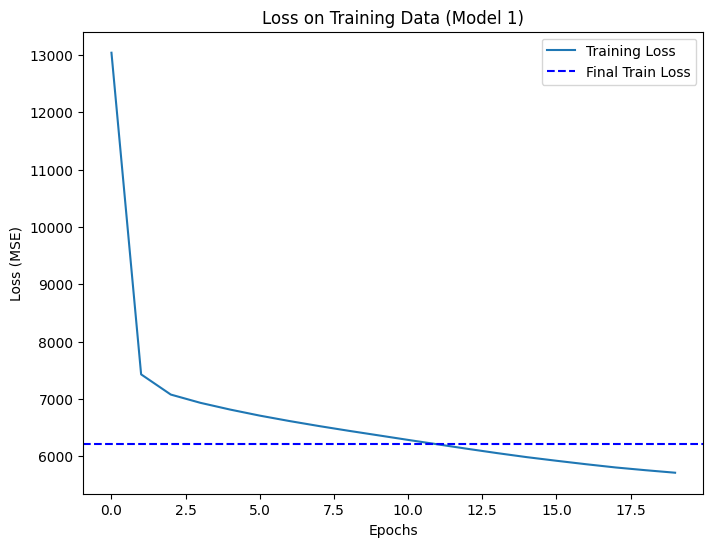

Final Training Loss (Model 1): 6210.8254


np.float64(6210.825445331623)

In [36]:
# Evaluating model 1
evaluate_model_training(model1, history1, X_train_scaled, y_train, model_name="Model 1")

In [37]:
generate_submission(
    model=model1,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model1.csv"
)


 25/411 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model1.csv


# Model 2

In [38]:
# Rebuild model2 with adjusted parameters like optimizers and othere
model2 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[128, 64],
    activation='tanh',
    dropout_rate=0.3,
    optimizer='rmsprop',
    learning_rate=0.0008,
    use_bidirectional=False
)

# Print model summary
model2.summary()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='loss',             # Use 'val_loss' if you use validation split
    patience=10,
    restore_best_weights=True
)

# Train the model
history2 = model2.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - lambda: 123.7053 - loss: 15972.0049
Epoch 2/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 100.4777 - loss: 10683.8281
Epoch 3/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 91.5958 - loss: 8874.0059
Epoch 4/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 89.0651 - loss: 8293.3389
Epoch 5/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - lambda: 87.1364 - loss: 8018.0845
Epoch 6/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - lambda: 82.9567 - loss: 7321.5190
Epoch 7/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 79.4175 - loss: 6709.4966
Epoch 8/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - lambda: 78.4378 - loss: 6520.5425
Epoch 9/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 77.1812 - loss: 6298.5200
Epoch 10/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - lambda: 74.9573 - loss: 5958.3418
Epoch 11/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 74.1032 - loss: 5830.4043
Epoch 12/20
959/959 ━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


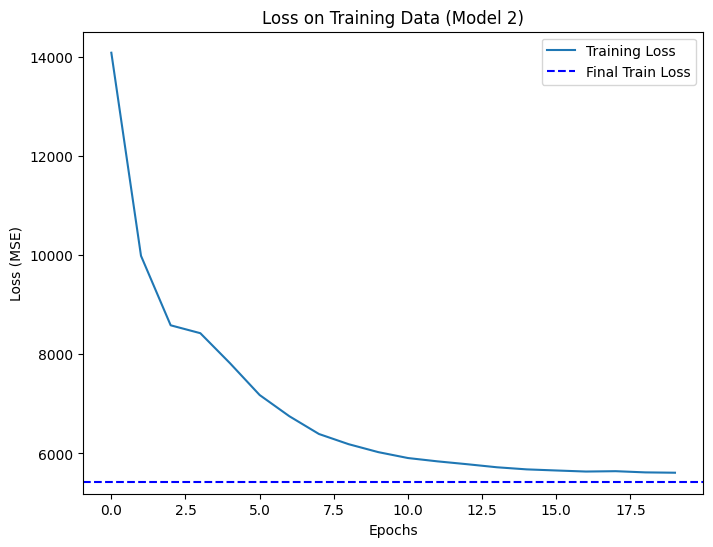

Final Training Loss (Model 2): 5432.2029


np.float64(5432.202916710656)

In [39]:
# Evaluating model 2
evaluate_model_training(model2, history2, X_train_scaled, y_train, model_name="Model 2")


In [40]:
generate_submission(
    model=model2,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model2.csv"
)


 53/411 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model2.csv


# Model 3

In [41]:
# Iterating again to see if we can outperform the above model

model3 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[128, 64],
    activation='tanh',
    dropout_rate=0.2,
    optimizer='adam',
    learning_rate=0.0003,
    use_bidirectional=False
)

# Print the model summary
model3.summary()

# Add early stopping
early_stopping = EarlyStopping(
    monitor='loss',                # Use 'val_loss' if validation set is used
    patience=10,
    restore_best_weights=True
)

# Train the model
history3 = model3.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - lambda: 127.1849 - loss: 16771.5801
Epoch 2/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - lambda: 112.6661 - loss: 13284.9414
Epoch 3/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - lambda: 104.9438 - loss: 11605.1816
Epoch 4/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 100.5571 - loss: 10662.2031
Epoch 5/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - lambda: 95.4083 - loss: 9614.6123
Epoch 6/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - lambda: 92.5024 - loss: 9137.0225
Epoch 7/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - lambda: 89.3461 - loss: 8431.1084
Epoch 8/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - lambda: 89.8781 - loss: 8490.8418
Epoch 9/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 85.7599 - loss: 7792.8003
Epoch 10/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - lambda: 83.8357 - loss: 7504.6035
Epoch 11/20
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - lambda: 81.2136 - loss: 7002.8735
Epoch 12/20
959/959

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


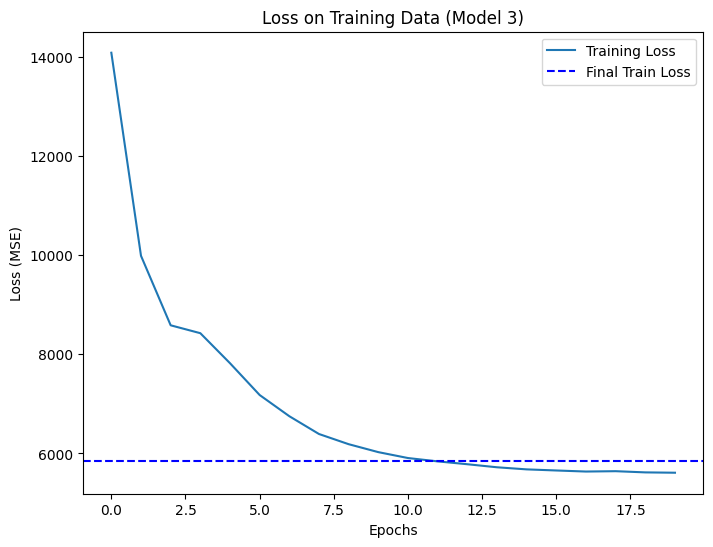

Final Training Loss (Model 3): 5840.6804


np.float64(5840.680405591054)

In [42]:
# Evaluating model 3
evaluate_model_training(model3, history2, X_train_scaled, y_train, model_name="Model 3")


In [43]:
generate_submission(
    model=model3,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model3.csv"
)

 18/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model3.csv


# Model 4

In [44]:
# Training model 4 with a different combination of parameters

model4 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[128, 64],
    activation='tanh',
    dropout_rate=0.15,
    optimizer='rmsprop',
    learning_rate=0.0003,
    use_bidirectional=False
)

early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

history4 = model4.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - lambda: 129.2825 - loss: 16991.4863 - val_lambda: 124.8314 - val_loss: 21524.1895
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - lambda: 118.6221 - loss: 14309.1797 - val_lambda: 119.1126 - val_loss: 20048.6172
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - lambda: 113.8678 - loss: 13189.8604 - val_lambda: 115.0499 - val_loss: 19016.3105
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - lambda: 111.7868 - loss: 12782.8740 - val_lambda: 111.2513 - val_loss: 18057.2207
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - lambda: 108.5506 - loss: 12059.5801 - val_lambda: 107.7220 - val_loss: 17162.6348
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - lambda: 104.0519 - loss: 11069.0107 - val_lambda: 104.4982 - val_loss: 16332.2646
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - lambda: 100.1684 - loss: 10292.9316 - val_lambda: 101.6085 - val_loss: 15566.7793
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - lam

959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


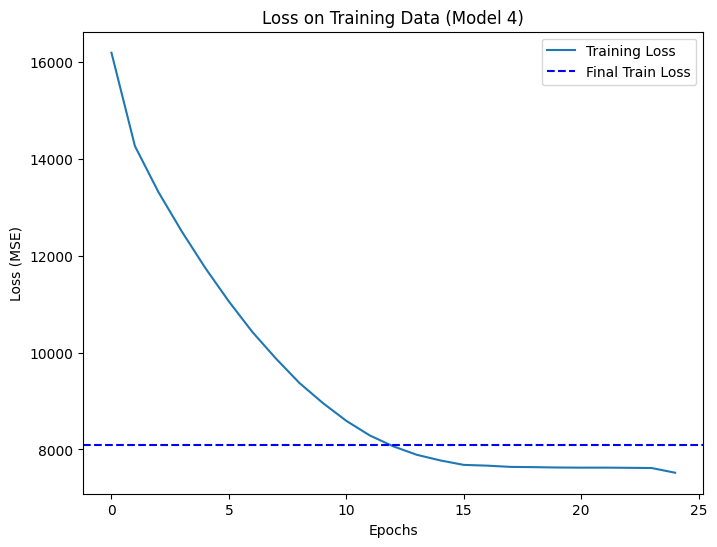

Final Training Loss (Model 4): 8101.0983


np.float64(8101.098262443052)

In [45]:
evaluate_model_training(model4, history4, X_train_scaled, y_train, model_name="Model 4")


In [46]:
generate_submission(
    model=model4,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model4.csv"
)

 53/411 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model4.csv


# Model 5

In [47]:
# Iteration with model 5

model5 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[256, 128, 64],
    activation='tanh',
    dropout_rate=0.1,
    optimizer='rmsprop',
    learning_rate=0.0002,
    use_bidirectional=False
)

early_stopping = EarlyStopping(monitor='loss', patience=12, restore_best_weights=True)

history5 = model5.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - lambda: 128.9873 - loss: 16883.2852 - val_lambda: 124.0003 - val_loss: 21305.0410
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - lambda: 119.2305 - loss: 14439.5361 - val_lambda: 121.0513 - val_loss: 20545.1895
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - lambda: 116.8545 - loss: 13932.1055 - val_lambda: 118.2638 - val_loss: 19831.9707
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - lambda: 114.6462 - loss: 13362.5586 - val_lambda: 115.5683 - val_loss: 19147.4883
Epoch 5/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - lambda: 112.2137 - loss: 12820.9619 - val_lambda: 112.9786 - val_loss: 18493.1309
Epoch 6/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - lambda: 110.5462 - loss: 12515.3115 - val_lambda: 110.4980 - val_loss: 17866.9160
Epoch 7/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - lambda: 107.9820 - loss: 11952.3779 - val_lambda: 108.1470 - val_loss: 17270.8945
Epoch 8/20
384/384 ━━━━━━━━━━━━━━━━━

959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


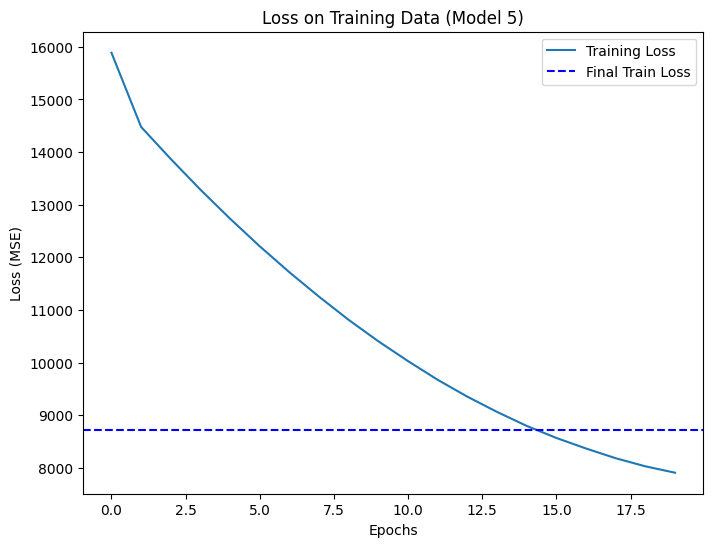

Final Training Loss (Model 5): 8720.1338


np.float64(8720.133844918202)

In [48]:
evaluate_model_training(model5, history5, X_train_scaled, y_train, model_name="Model 5")

In [49]:
generate_submission(
    model=model5,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model5.csv"
)

 30/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model5.csv


# Trying out bidirectional LSTMs

With iterations failing to reduce the error with even different combinations of hyperparameters and optimizers, let us try bidirectional LSTMs to see if we can do better


## Model 6

In [50]:
# Bidirectional model trainings and evaluation
model6 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[128, 64],
    activation='tanh',
    dropout_rate=0.2,
    optimizer='adam',
    learning_rate=0.0003,
    use_bidirectional=True
)

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history6 = model6.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs= 30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - lambda: 120.4470 - loss: 15080.6123 - val_lambda: 99.0986 - val_loss: 16677.5020
Epoch 2/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - lambda: 99.4033 - loss: 10390.1211 - val_lambda: 91.2414 - val_loss: 14274.7275
Epoch 3/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - lambda: 91.8088 - loss: 8858.1982 - val_lambda: 87.8261 - val_loss: 12878.5029
Epoch 4/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - lambda: 87.4583 - loss: 8086.8491 - val_lambda: 86.7708 - val_loss: 12110.5215
Epoch 5/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - lambda: 85.7035 - loss: 7696.5356 - val_lambda: 86.7017 - val_loss: 11734.5498
Epoch 6/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - lambda: 84.3132 - loss: 7490.1934 - val_lambda: 79.8634 - val_loss: 10800.1416
Epoch 7/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - lambda: 80.9426 - loss: 6951.6504 - val_lambda: 77.1381 - val_loss: 10127.3398
Epoch 8/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step

959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


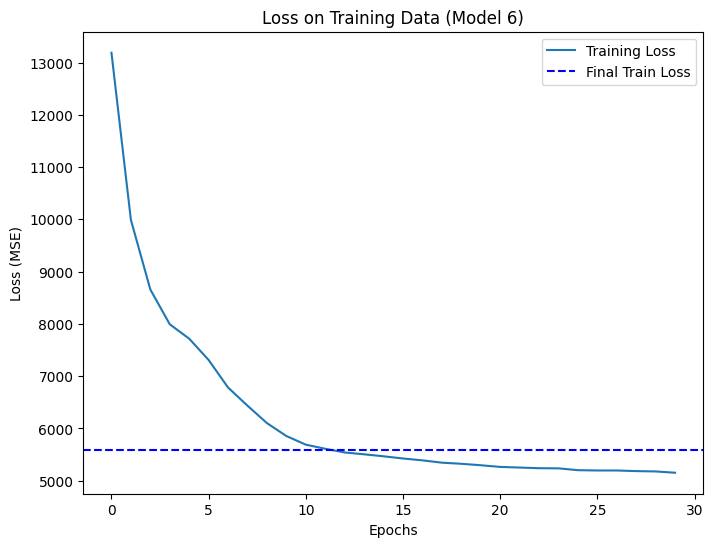

Final Training Loss (Model 6): 5591.5195


np.float64(5591.51945180494)

In [51]:
evaluate_model_training(model6, history6, X_train_scaled, y_train, model_name="Model 6")

In [52]:
generate_submission(
    model=model6,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model6.csv"
)

 37/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model6.csv


## Model 7

In [53]:
#Trying out another iteration

model7 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[256, 128, 64],
    activation='tanh',
    dropout_rate=0.15,
    optimizer='rmsprop',
    learning_rate=0.0002,
    use_bidirectional=True
)

early_stopping = EarlyStopping(monitor='loss', patience=12, restore_best_weights=True)

history7 = model7.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - lambda: 124.5677 - loss: 15785.3301 - val_lambda: 119.1705 - val_loss: 20063.3242
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - lambda: 116.6443 - loss: 13885.3096 - val_lambda: 113.8800 - val_loss: 18720.6836
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - lambda: 108.9403 - loss: 12116.7607 - val_lambda: 109.0255 - val_loss: 17494.1133
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - lambda: 106.4077 - loss: 11634.1650 - val_lambda: 104.6906 - val_loss: 16382.4053
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - lambda: 101.5246 - loss: 10595.9346 - val_lambda: 100.9440 - val_loss: 15386.5801
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - lambda: 98.4682 - loss: 9957.8916 - val_lambda: 97.7981 - val_loss: 14502.2559
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - lambda: 95.3851 - loss: 9361.1318 - val_lambda: 95.2518 - val_loss: 13726.8486
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 

959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step


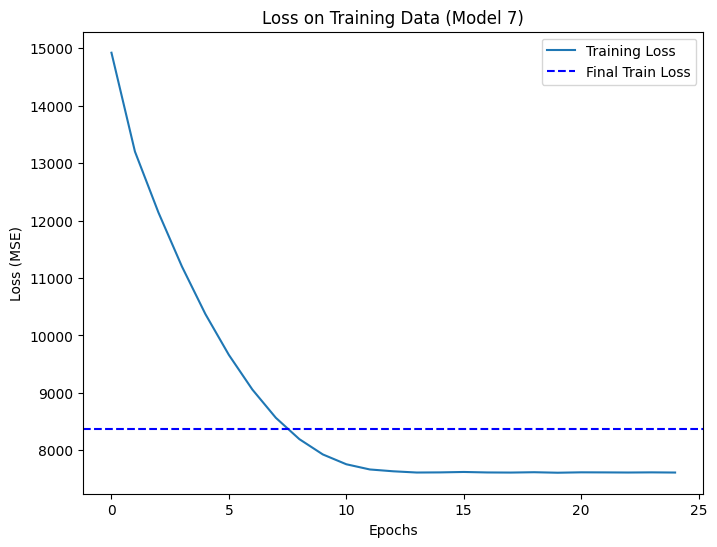

Final Training Loss (Model 7): 8377.2875


np.float64(8377.28747523625)

In [54]:
evaluate_model_training(model7, history7, X_train_scaled, y_train, model_name="Model 7")

In [55]:
generate_submission(
    model=model7,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model7.csv"
)

 18/411 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model7.csv


# Model 8

In [56]:
# Iterating model 8
model8 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[128, 64, 32],
    activation='relu',
    dropout_rate=0.3,
    optimizer='rmsprop',
    learning_rate=0.0005,
    use_bidirectional=True
)

# Show the model architecture
model8.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='loss',             # Can also be 'loss' if no val split
    patience=10,
    restore_best_weights=True
)

# Train the model
history8 = model8.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 1, 256)         │       141,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 1, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,945 (1.32 MB)

 Trainable params: 346,945 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - lambda: 100.4422 - loss: 10942.1436 - val_lambda: 80.3788 - val_loss: 10947.4717
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - lambda: 80.6348 - loss: 6897.7876 - val_lambda: 76.6193 - val_loss: 9973.0625
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - lambda: 79.1872 - loss: 6621.6831 - val_lambda: 73.3506 - val_loss: 8718.0752
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - lambda: 75.9290 - loss: 6155.9077 - val_lambda: 71.0393 - val_loss: 8099.2856
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - lambda: 75.1445 - loss: 5926.6348 - val_lambda: 69.7771 - val_loss: 7940.1577
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - lambda: 73.8980 - loss: 5767.1152 - val_lambda: 69.3627 - val_loss: 7572.7393
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - lambda: 73.4978 - loss: 5727.3730 - val_lambda: 68.8096 - val_loss: 7763.4380
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - lam

959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


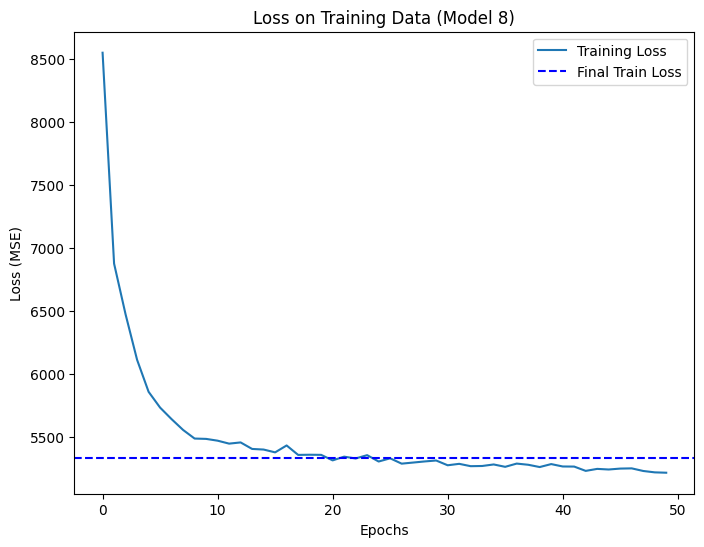

Final Training Loss (Model 8): 5329.9758


np.float64(5329.975776698914)

In [57]:
evaluate_model_training(model8, history8, X_train_scaled, y_train, model_name="Model 8")

In [58]:
generate_submission(
    model=model8,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model8.csv"
)

 11/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model8.csv


# Model 9

In [60]:
# Iterating with sdg

model9 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[128, 64],
    activation='tanh',
    dropout_rate=0.25,
    optimizer='sgd',
    learning_rate=0.01,
    use_bidirectional=True
)

early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)

history9 = model9.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - lambda: 82.7757 - loss: 7315.7383 - val_lambda: 70.6868 - val_loss: 7896.5591
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - lambda: 74.5667 - loss: 5901.0986 - val_lambda: 73.1089 - val_loss: 9012.3574
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - lambda: 75.1149 - loss: 5988.8159 - val_lambda: 74.4382 - val_loss: 8392.4678
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - lambda: 74.3099 - loss: 5791.7803 - val_lambda: 74.2554 - val_loss: 7991.8418
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - lambda: 75.5395 - loss: 6017.1870 - val_lambda: 71.7443 - val_loss: 8281.0098
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - lambda: 73.8683 - loss: 5807.1914 - val_lambda: 70.6754 - val_loss: 7846.0796
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - lambda: 74.8318 - loss: 5934.7817 - val_lambda: 76.7598 - val_loss: 7829.1323
Epoch 8/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - lambda: 72

959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


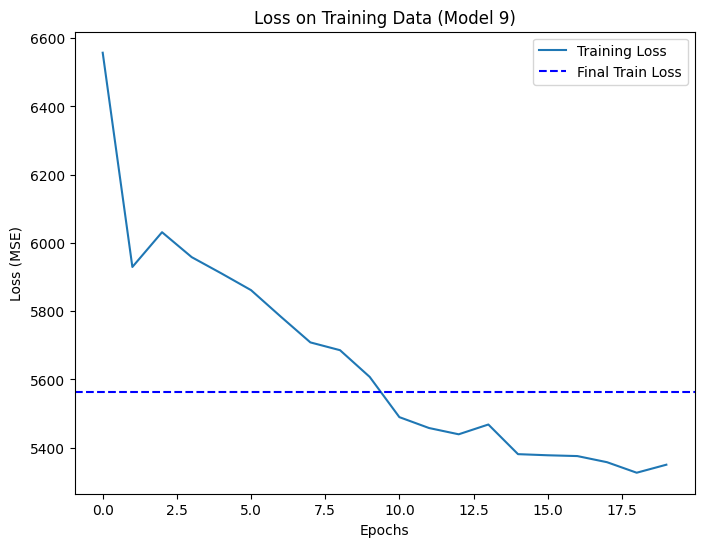

Final Training Loss (Model 9): 5563.8195


np.float64(5563.819534337057)

In [61]:
evaluate_model_training(model9, history9, X_train_scaled, y_train, model_name="Model 9")

In [62]:
generate_submission(
    model=model9,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model9.csv"
)

 40/411 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model9.csv


# Model 10

In [63]:
# Iterating with model 10

model10 = build_lstm_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    lstm_units=[256],
    activation='tanh',
    dropout_rate=0.1,
    optimizer='adam',
    learning_rate=0.0002,
    use_bidirectional=True
)

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history10 = model10.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - lambda: 129.4982 - loss: 17003.7695 - val_lambda: 126.4508 - val_loss: 21951.4707
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - lambda: 116.4908 - loss: 13815.7988 - val_lambda: 106.5622 - val_loss: 16937.5781
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - lambda: 99.2112 - loss: 10159.2881 - val_lambda: 93.7307 - val_loss: 13441.3262
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - lambda: 88.8790 - loss: 8214.0820 - val_lambda: 89.9537 - val_loss: 12002.8145
Epoch 5/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - lambda: 85.9426 - loss: 7600.6680 - val_lambda: 88.8118 - val_loss: 11462.0859
Epoch 6/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - lambda: 82.7940 - loss: 7074.7461 - val_lambda: 88.0988 - val_loss: 11238.8838
Epoch 7/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - lambda: 82.4437 - loss: 6991.4751 - val_lambda: 87.5366 - val_loss: 11096.8320
Epoch 8/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step

959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


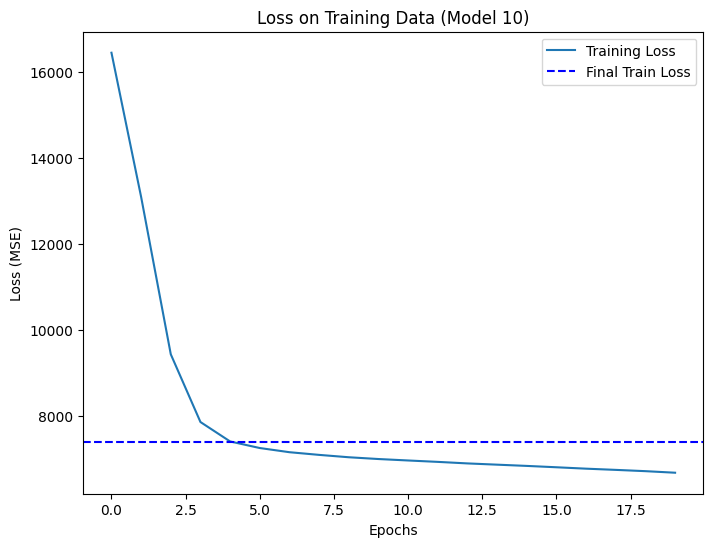

Final Training Loss (Model 10): 7395.1795


np.float64(7395.179482950004)

In [64]:
evaluate_model_training(model10, history10, X_train_scaled, y_train, model_name="Model 10")

In [65]:
generate_submission(
    model=model10,
    df_test=df_test,
    scaler=scaler,
    save_path="/content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions",
    file_name="subm_model10.csv"
)

 11/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step  

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Submission saved to: /content/drive/MyDrive/Colab_Notebooks/Data/Kaggle_Submissions/subm_model10.csv


# Findings

There is no straight variation about the parameters. Some basic LSTMS performed better than Bidirectional LSTMs when the expectations before training was that all bidirectional LSTMS should perform better than basic one, which was not the case.

- Adam and RMSprop (with learning rates ~0.0002–0.0005) performed better than SGD, which required careful tuning and more epochs to converge.
- Lower learning rates (e.g., 0.0002) helped stabilize training, while higher rates (e.g., 0.01 with SGD) led to erratic loss curves.
- Models with multiple LSTM layers (e.g., 256-128-64 units) and dropout (0.1–0.3) showed better generalization than shallow networks generally. This goes without saying that early stopping played a crucial part in enhancing a model's performance
